In [ ]:
"""
What we want to achieve in this notebook:
- Pairwise Wilcoxon signed-rank + Holm correction (SciPy) + Critical Difference plot
"""
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

root_folder = os.getcwd()

DATA_PATH = "performance_comparison_gauss_1_clean.csv"      # path to your CSV
CSV_SEPARATOR = ","           # usually "," or ";"
DROP_AVERAGE_ROW = True       # drop last row if it is an average
LOWER_IS_BETTER = True       # True for errors (RMSE, MAE), False for scores
ALPHA = 0.05                  # significance level for our tests

df_path = os.path.join(root_folder, "data", "synthetic-golden-standard", "output-analysis")
data = pd.read_csv(os.path.join(df_path, DATA_PATH), sep=CSV_SEPARATOR)
print(data.head(2))
df = data[["HOG", "SCHARR", "SOBEL", "FIJI"]]
df

               Filename       HOG    SCHARR     SOBEL      FIJI
0  concentric_circles15  2.838564  0.426311  0.345691  0.332859
1  concentric_circles25  2.534272  0.352346  0.190710  0.354312


,HOG,SCHARR,SOBEL,FIJI
0,2.838564,0.426311,0.345691,0.332859
1,2.534272,0.352346,0.190710,0.354312
2,2.480698,0.341830,0.230949,0.362329
3,81.628888,17.497065,16.966389,8.685144
4,65.577875,7.953317,7.629444,6.141524
...,...,...,...,...
58,66.122918,1.315254,1.399789,2.082285
59,62.599016,3.573468,3.763342,3.609971
60,66.349290,2.049501,1.598974,0.864726
61,66.181452,2.007990,1.999420,0.705808


In [52]:
from scipy.stats import rankdata, studentized_range

def mean_ranks(df: pd.DataFrame, higher_is_better: bool) -> pd.Series:
    """Mean ranks across rows; rank 1 = best."""
    x = df.to_numpy(dtype=float)
    ranks = np.zeros_like(x)
    for i in range(x.shape[0]):
        ranks[i] = rankdata(-x[i] if higher_is_better else x[i], method="average")
    return pd.Series(ranks.mean(axis=0), index=df.columns, name="mean_rank")


def nemenyi_cd(n_datasets: int, n_methods: int, alpha: float = 0.05) -> float:
    """
    Nemenyi critical difference for average ranks (Demšar 2006).
    CD = q_alpha * sqrt(k(k+1)/(6N))
    where q_alpha comes from the Studentized range distribution.
    """
    if n_datasets <= 1:
        raise ValueError("Need at least 2 datasets/rows to compute CD.")
    if n_methods <= 1:
        raise ValueError("Need at least 2 methods/columns to compute CD.")

    # Studentized range critical value q_alpha for k groups, infinite dof
    q_alpha = studentized_range.ppf(1 - alpha, n_methods, np.inf)
    se = np.sqrt(n_methods * (n_methods + 1) / (6.0 * n_datasets))
    return float(q_alpha * se)


def nemenyi_pvals(mean_rank: pd.Series, n_datasets: int) -> pd.DataFrame:
    """
    Pairwise p-values for Nemenyi test based on average ranks.
    p = 1 - CDF_studentized_range(q), where
    q = |ri - rj| / sqrt(k(k+1)/(6N))
    """
    methods = list(mean_rank.index)
    k = len(methods)
    se = np.sqrt(k * (k + 1) / (6.0 * n_datasets))

    pmat = np.ones((k, k), dtype=float)
    for i in range(k):
        for j in range(i + 1, k):
            q = abs(mean_rank.iloc[i] - mean_rank.iloc[j]) / se
            p = 1.0 - studentized_range.cdf(q, k, np.inf)
            pmat[i, j] = p
            pmat[j, i] = p

    return pd.DataFrame(pmat, index=methods, columns=methods)


def _contiguous_nonsig_segments(
    mean_rank_sorted: pd.Series, cd: float
) -> list[tuple[int, int]]:
    """
    Find contiguous segments (in sorted-by-rank order) where *all* pairs
    within the segment have rank differences <= CD (i.e., not significant
    under Nemenyi at alpha).

    Returns list of (start_idx, end_idx) inclusive indices in the sorted list.
    """
    r = mean_rank_sorted.to_numpy()
    k = len(r)
    segments: list[tuple[int, int]] = []

    # Brute-force maximal contiguous segments:
    # segment [i, j] is valid if max(r[i..j]) - min(r[i..j]) <= CD,
    # but since r is sorted increasing, that's r[j]-r[i] <= CD.
    i = 0
    while i < k:
        j = i
        while j + 1 < k and (r[j + 1] - r[i]) <= cd:
            j += 1
        # Only draw segments of length >= 2
        if j > i:
            segments.append((i, j))
        i += 1

    # Reduce overlaps a bit: keep only segments that are not strict subsegments
    reduced: list[tuple[int, int]] = []
    for a, b in segments:
        is_sub = any((c <= a and b <= d) and ((c, d) != (a, b)) for c, d in segments)
        if not is_sub:
            reduced.append((a, b))

    # Sort by length descending then by start
    reduced.sort(key=lambda t: (-(t[1] - t[0]), t[0]))
    return reduced


def critical_difference_diagram(
    df: pd.DataFrame,
    *,
    higher_is_better: bool = True,
    alpha: float = 0.05,
    title: str | None = None,
    figsize: tuple[float, float] = (10, 3.2),
    label_rotation: float = 25.0,
) -> tuple[plt.Figure, plt.Axes]:
    """
    Create a Demšar-style Critical Difference (CD) diagram with Nemenyi post-hoc.
    df: rows = datasets, cols = methods.
    """
    if df.isna().any().any():
        raise ValueError("df contains NaNs. Please impute/drop before plotting.")

    n_datasets = df.shape[0]
    n_methods = df.shape[1]

    mr = mean_ranks(df, higher_is_better=higher_is_better)
    mr_sorted = mr.sort_values()  # rank 1 best, so smaller is better
    cd = nemenyi_cd(n_datasets=n_datasets, n_methods=n_methods, alpha=alpha)

    # Prepare plot
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_axis_off()

    # Axis range (ranks are between 1..k)
    k = n_methods
    xmin, xmax = 1.0, float(k)
    pad = 0.6
    ax.set_xlim(xmin - pad, xmax + pad)
    ax.set_ylim(0, 1)

    # Baseline y levels
    y_axis = 0.35
    y_labels = 0.18
    y_groups_top = 0.62

    # Draw rank axis
    ax.hlines(y_axis, xmin, xmax, linewidth=1.2)
    for r in range(1, k + 1):
        ax.vlines(r, y_axis - 0.02, y_axis + 0.02, linewidth=1.0)
        ax.text(r, y_axis - 0.07, str(r), ha="center", va="top", fontsize=9)

    # Method markers + labels
    for name, rank in mr_sorted.items():
        ax.plot([rank], [y_axis], marker="o", markersize=11)
        ax.text(
            rank,
            y_labels,
            name,
            ha="right",
            va="center",
            rotation=label_rotation,
            fontsize=12,
        )

    # CD bar (like Orange)
    cd_x0 = xmin
    cd_x1 = min(xmax, xmin + cd)
    ax.hlines(0.88, cd_x0, cd_x1, linewidth=2.0)
    ax.vlines(cd_x0, 0.86, 0.90, linewidth=2.0)
    ax.vlines(cd_x1, 0.86, 0.90, linewidth=2.0)
    ax.text((cd_x0 + cd_x1) / 2, 0.91, f"CD = {cd:.3f} (α={alpha})", ha="center", va="bottom", fontsize=10)

    # Non-significant groups as thick bars above axis
    segments = _contiguous_nonsig_segments(mr_sorted, cd=cd)
    # stack bars to avoid overlap
    level_step = 0.06
    used_levels: list[list[tuple[float, float]]] = []

    def place_segment(x0: float, x1: float) -> float:
        for level_idx, intervals in enumerate(used_levels):
            if all(x1 < a or x0 > b for a, b in intervals):
                intervals.append((x0, x1))
                return y_groups_top + level_idx * level_step
        used_levels.append([(x0, x1)])
        return y_groups_top + (len(used_levels) - 1) * level_step

    for i, j in segments:
        ranks = mr_sorted.to_numpy()
        x0, x1 = float(ranks[i]), float(ranks[j])
        y = place_segment(x0, x1)
        ax.hlines(y, x0, x1, linewidth=4.0)

    if title is None:
        title = "Critical Difference Diagram (Nemenyi)"
    ax.text((xmin + xmax) / 2, 1.05, title, ha="center", va="top", fontsize=12)

    return fig, ax

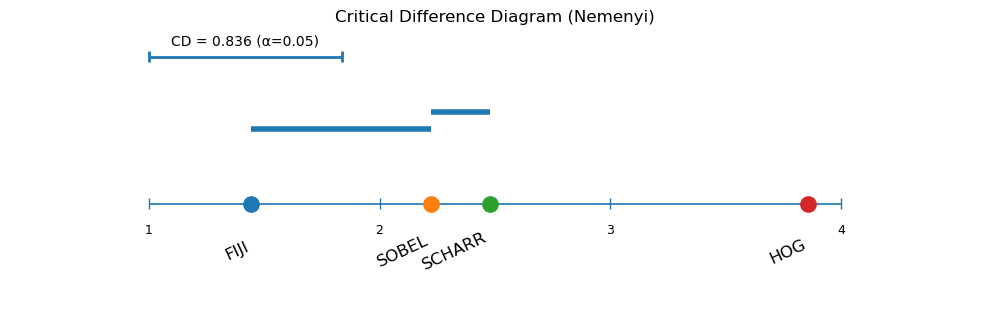

In [53]:
fig, ax = critical_difference_diagram(df, higher_is_better=not LOWER_IS_BETTER, alpha=ALPHA)
plt.tight_layout()
plt.show()